In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2 

# PyTorch (Deep Learning)
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor

# Progress bar
from tqdm import tqdm

# Explainability (for later)
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers


2025-07-06 16:00:26.620315: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Exploratory Data Analysis

In [4]:
clinical_data = pd.read_csv("Data/HMU-GC-Clinical.csv")

In [5]:
clinical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 17 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Patient                                                  300 non-null    int64  
 1   Sex                                                      300 non-null    object 
 2   Age                                                      300 non-null    int64  
 3   T staging                                                300 non-null    object 
 4   N staging                                                300 non-null    object 
 5   M staging                                                300 non-null    object 
 6   Comprehensive Staging                                    300 non-null    object 
 7   Histological Type                                        300 non-null    object 
 8   Lauren classification(Intestin

In [6]:
clinical_data.head()

,Patient,Sex,Age,T staging,N staging,M staging,Comprehensive Staging,Histological Type,"Lauren classification(Intestinal=0, Mixed=1, Diffuse=2)",Lymphovascular Invasion(Negative=0，Positive=1),Venous Invasion(Negative=0，Positive=1),Perineural Invasion(Negative=0，Positive=1),Stroma Quantity(Medullary=0，Intermediate=1，Scirrhous=2),Tumor Infiltration Pattern,HER-2(Negative=0，1=1+，2=2+，3=3+),Unnamed: 15,Unnamed: 16
0,1600097,Male,45,T1b,N0,M0,ⅠA,Mucinous adenocarcinoma,0.0,1.0,1.0,1.0,1.0,INFc,0,NaN,NaN
1,1502891,Male,48,T3,N2,M0,ⅢA,Tubular adenocarcinoma,0.0,1.0,1.0,1.0,1.0,INFb,1,NaN,NaN
2,1606490,Male,76,T3,N3a,M0,ⅢB,Mucinous adenocarcinoma,NaN,0.0,0.0,1.0,1.0,INFb,1,NaN,NaN
3,1422911,Male,72,T4b,N1,M0,ⅢB,Tubular adenocarcinoma,1.0,NaN,NaN,1.0,1.0,INFa,0,NaN,NaN
4,1434665,Male,72,T4a,N0,M0,ⅡB,Tubular adenocarcinoma,0.0,0.0,0.0,1.0,2.0,INFa,2,NaN,NaN


There are two unnamed columns which can be removed.

In [7]:
clinical_data.drop('Unnamed: 15', inplace=True, axis=1)
clinical_data.drop('Unnamed: 16', inplace=True, axis=1)

In [8]:
clinical_data.head()

,Patient,Sex,Age,T staging,N staging,M staging,Comprehensive Staging,Histological Type,"Lauren classification(Intestinal=0, Mixed=1, Diffuse=2)",Lymphovascular Invasion(Negative=0，Positive=1),Venous Invasion(Negative=0，Positive=1),Perineural Invasion(Negative=0，Positive=1),Stroma Quantity(Medullary=0，Intermediate=1，Scirrhous=2),Tumor Infiltration Pattern,HER-2(Negative=0，1=1+，2=2+，3=3+)
0,1600097,Male,45,T1b,N0,M0,ⅠA,Mucinous adenocarcinoma,0.0,1.0,1.0,1.0,1.0,INFc,0
1,1502891,Male,48,T3,N2,M0,ⅢA,Tubular adenocarcinoma,0.0,1.0,1.0,1.0,1.0,INFb,1
2,1606490,Male,76,T3,N3a,M0,ⅢB,Mucinous adenocarcinoma,NaN,0.0,0.0,1.0,1.0,INFb,1
3,1422911,Male,72,T4b,N1,M0,ⅢB,Tubular adenocarcinoma,1.0,NaN,NaN,1.0,1.0,INFa,0
4,1434665,Male,72,T4a,N0,M0,ⅡB,Tubular adenocarcinoma,0.0,0.0,0.0,1.0,2.0,INFa,2


In [9]:
clinical_data.describe()

,Patient,Age,"Lauren classification(Intestinal=0, Mixed=1, Diffuse=2)",Lymphovascular Invasion(Negative=0，Positive=1),Venous Invasion(Negative=0，Positive=1),Perineural Invasion(Negative=0，Positive=1),Stroma Quantity(Medullary=0，Intermediate=1，Scirrhous=2),HER-2(Negative=0，1=1+，2=2+，3=3+)
count,3.000000e+02,300.000000,245.000000,250.000000,217.000000,248.000000,282.000000,300.000000
mean,1.514434e+06,60.766667,0.342857,0.568000,0.571429,0.633065,0.882979,0.866667
std,8.459544e+04,9.088871,0.618035,0.496348,0.496016,0.482943,0.537353,0.979159
min,1.400865e+06,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.423292e+06,55.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.521058e+06,61.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.606738e+06,66.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.644989e+06,79.000000,2.000000,1.000000,1.000000,1.000000,2.000000,3.000000


Mean age of the patients is ~60-61 years. Rest of them are categorical variables, so describe() is meaningless. So we can look at the value counts of the other columns to see the distribution. And plot a pie chart for easy understanding.

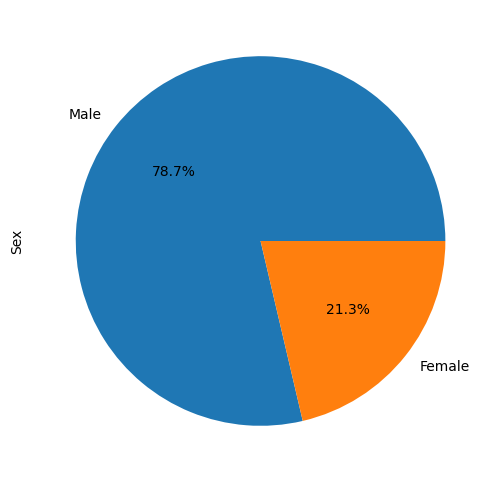

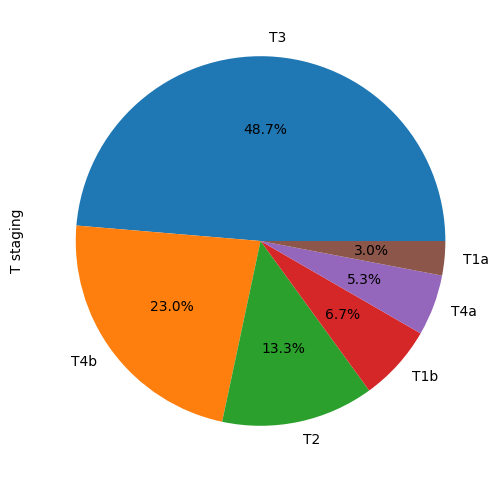

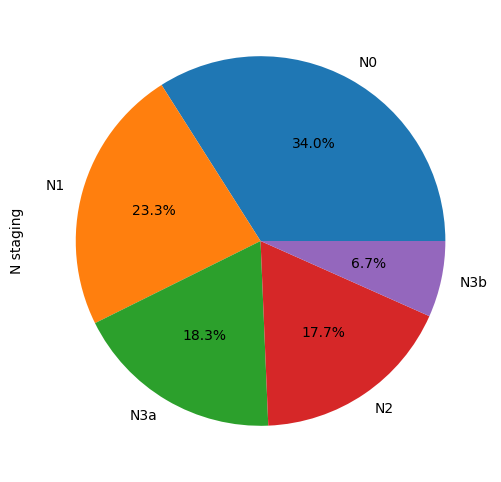

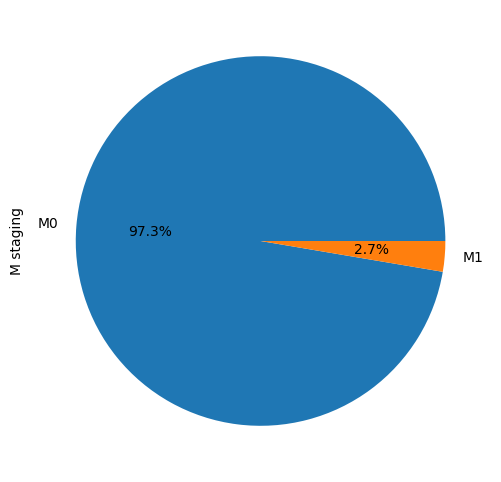

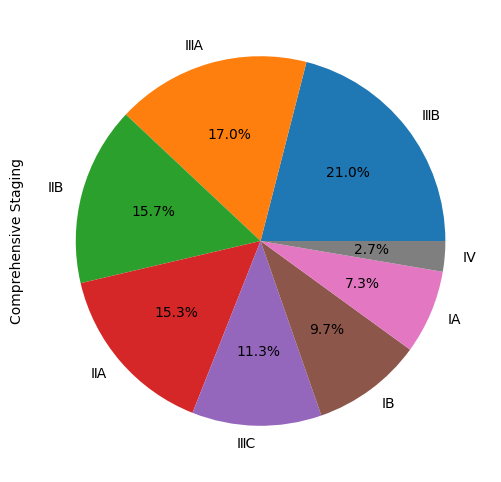

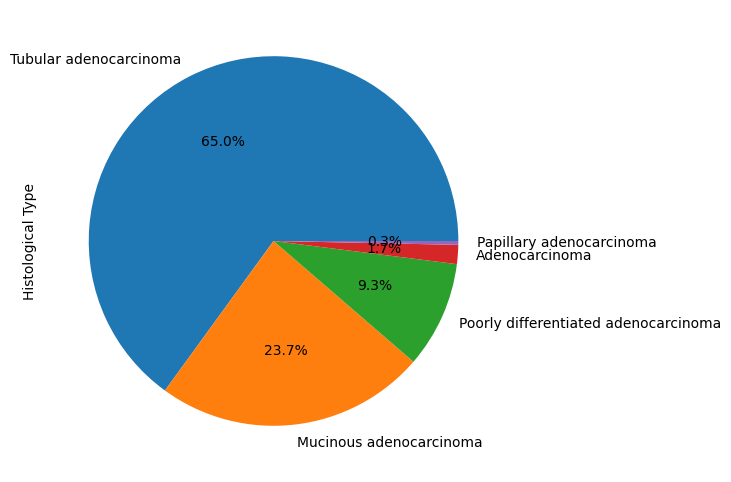

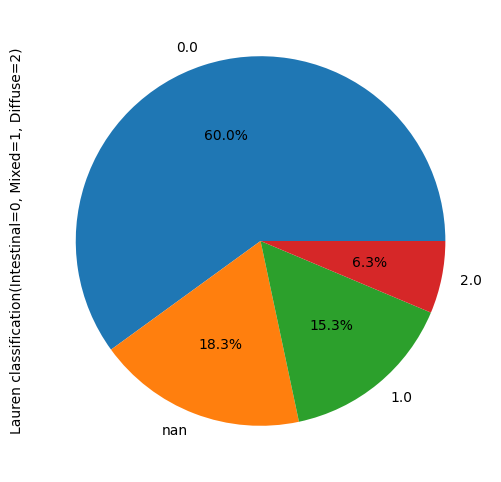

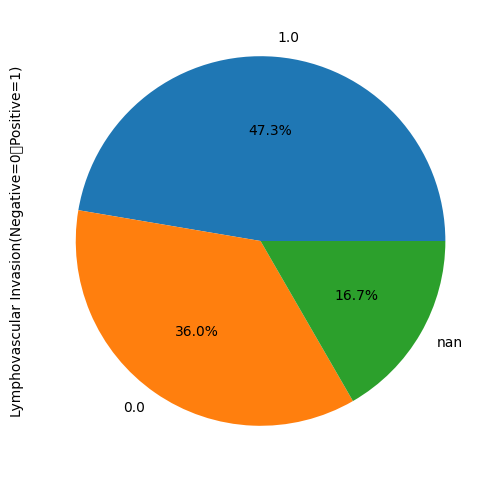

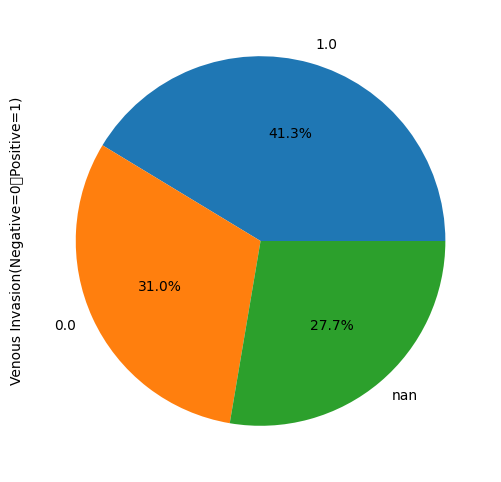

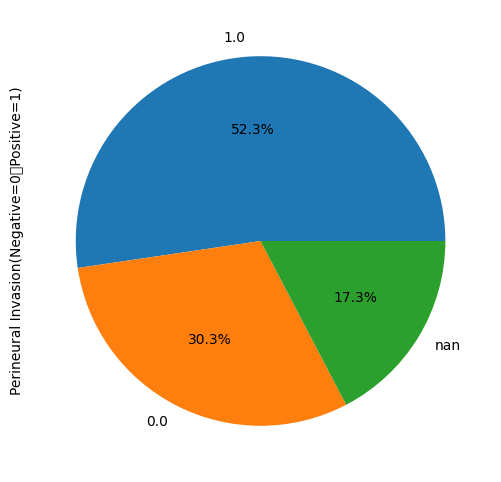

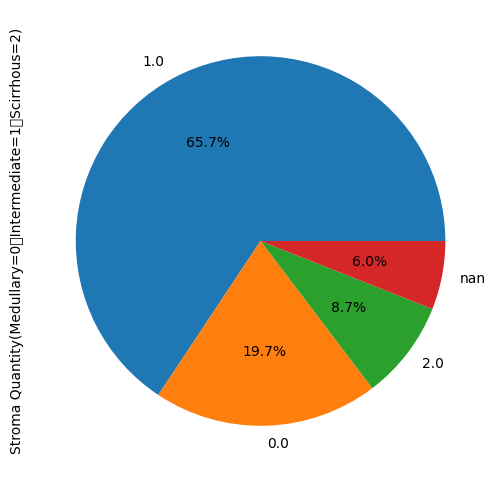

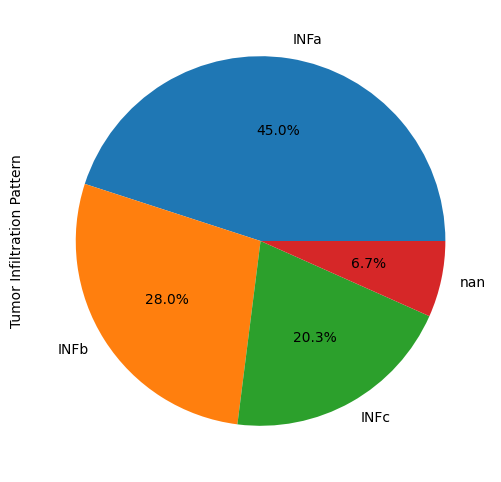

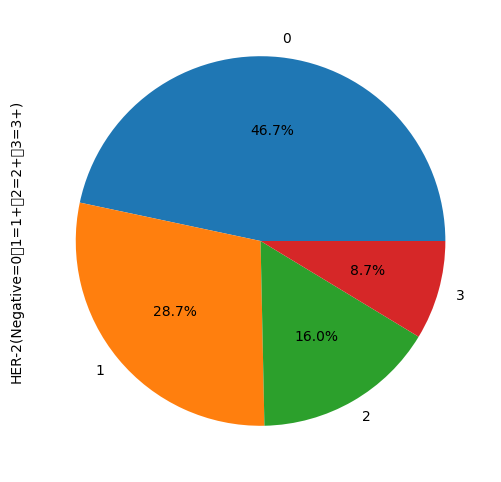

In [10]:
for col in clinical_data:
    if col not in ["Patient","Age"]:
        category_counts= clinical_data[col].value_counts(dropna=False)
        category_counts.plot(kind='pie',autopct='%1.1f%%',figsize=(6,6))
        plt.show()

In [11]:
for col in clinical_data:
    if col not in ["Patient","Age"]:
        print(f"\n{col} Distribution:")
        print(clinical_data[col].value_counts(dropna=False))


Sex Distribution:
Male      236
Female     64
Name: Sex, dtype: int64

T staging Distribution:
T3     146
T4b     69
T2      40
T1b     20
T4a     16
T1a      9
Name: T staging, dtype: int64

N staging Distribution:
N0     102
N1      70
N3a     55
N2      53
N3b     20
Name: N staging, dtype: int64

M staging Distribution:
M0    292
M1      8
Name: M staging, dtype: int64

Comprehensive Staging Distribution:
ⅢB    63
ⅢA    51
ⅡB    47
ⅡA    46
ⅢC    34
ⅠB    29
ⅠA    22
Ⅳ      8
Name: Comprehensive Staging, dtype: int64

Histological Type Distribution:
Tubular adenocarcinoma                  195
Mucinous adenocarcinoma                  71
Poorly differentiated adenocarcinoma     28
Adenocarcinoma                            5
Papillary adenocarcinoma                  1
Name: Histological Type, dtype: int64

Lauren classification(Intestinal=0, Mixed=1, Diffuse=2) Distribution:
0.0    180
NaN     55
1.0     46
2.0     19
Name: Lauren classification(Intestinal=0, Mixed=1, Diffuse=2), dty

When it comes to some categories such as Lauren classification, 
Lymphovascular Invasion etc., there are some cases which couldnt be classified properly which is named as Nan. We don't need it right now for the image classification task, but later if we need to extend it to multimodal classification, we need to find a way to impute those categories. For now we are just trying to understand the data and take a note of everything we might need to fix later.

* This dataset is skewed towards men. ~78% of the sample is men. Need to figure out if this skewness informational or a sample bias. 

* T staging refers to the "Tumor" component in the TNM cancer staging system, which is used to describe the extent of cancer in a standardized way. T0: No evidence of primary tumor. T1a, T1b are early stage tumors. T2- intermediate. T3- Locally advanced, but has not reached outer layers. T4a - Reached the surface of the stomach wall . T4b - Advanced, Invading nearby organs. Most patients in this sample belong to T3 and T4b.

* M Staging (Distant Metastasis) - M0 means no distant mets, M1 is Distant metastasis present. ~97% of the patients dont have distant mets yet. 

* Comprehensive staging also tells the same story. Only ~3%  patients are stage 4 patients which means those having distant metastatisis.

In [12]:
path = "Data/HMU-GC-HE-30K/all_image"
tissue_types = os.listdir(path)
print(tissue_types)

['ADI', 'MUC', 'NOR', 'LYM', 'DEB', 'MUS', 'TUM', 'STR']


In [16]:
for tissue in tissue_types:
    folder_path = os.path.join(path, tissue)
    if os.path.isdir(folder_path):
        num_images = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        print(f"{tissue}: {num_images} images")

ADI: 3887 images
MUC: 3887 images
NOR: 3887 images
LYM: 3887 images
DEB: 3887 images
MUS: 3887 images
TUM: 3887 images
STR: 3887 images


In [15]:
train_ds, valid_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  labels='inferred',
  #class_names=['normal', 'glioma_tumor','meningioma_tumor','pituitary_tumor'],
  validation_split=0.1,
  subset='both',
  seed=80,
  batch_size=32,
  image_size=(224, 224),
  shuffle=True
  )



Found 31096 files belonging to 8 classes.
Using 27987 files for training.
Using 3109 files for validation.


(-0.5, 223.5, 223.5, -0.5)

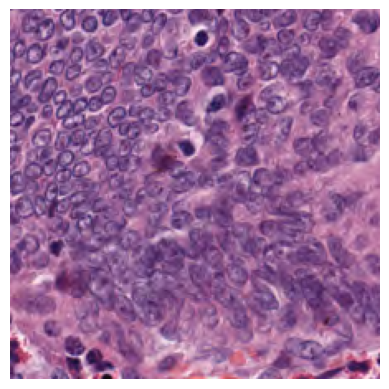

In [33]:
img = plt.imread(path + '/' + tissue_types[6]+'/'+ "TUM_12.png")
plt.imshow(img)
plt.axis('off')

In [ ]:
for i in range()

The dataset focuses on the tumor microenvironment (TME) and includes images categorized into eight distinct tissue types:

    ADI: Adipose (fat tissue) 🧈
    BACK: Background (non-tissue areas) 🌫️
    DEB: Debris (cellular waste) 🗑️
    LYM: Lymphocytes (immune cells) 🛡️
    MUC: Mucus (protective secretion) 🧴
    MUS: Smooth Muscle (muscle tissue) 💪
    NORM: Normal Colon Mucosa (healthy tissue for reference) 🌱
    STR: Cancer-associated Stroma (connective tissue around the tumor) 🕸️
    TUM: Tumor (cancerous tissue) 